<a href="https://colab.research.google.com/github/shleppich/chto-to/blob/main/task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
!pip install pandas natasha pymystem3 ipymarkup nltk matplotlib seaborn scikit-learn


In [58]:
import json
import pymystem3
import nltk
import nltk
from natasha import (
Segmenter,
MorphVocab,
NewsEmbedding,
NewsMorphTagger,
NewsSyntaxParser,
NewsNERTagger,
PER,
NamesExtractor,
Doc
)
from ipymarkup import show_dep_ascii_markup as show_markup
import pandas as pd
articles =  pd.read_json("articles.json")
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [28]:
segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)
sent_tokens = []

In [39]:
for content in articles:
    text = articles.get('content')
    text = [item for item in text if item]
    if text:
      doc = Doc(text[0])
      doc.segment(segmenter)
      doc.parse_syntax(syntax_parser)
      doc.tag_morph(morph_tagger)

      for sentence in doc.sents: # получаем предложения
        # При принте синтаксиса вылетает ошибка "max() iterable argument is empty"
        #sentence.syntax.print()
        sent_tokens.append([])
        for token in sentence.tokens: # получаем токены
            print(token)
            sent_tokens[-1].append(token)

DocToken(stop=7, text='Надоело', id='1_1', head_id='1_0', rel='root', pos='PART')
DocToken(start=8, stop=14, text='читать', id='1_2', head_id='1_1', rel='csubj', pos='VERB', feats=<Imp,Inf,Act>)
DocToken(start=15, stop=18, text='про', id='1_3', head_id='1_4', rel='case', pos='ADP')
DocToken(start=19, stop=26, text='события', id='1_4', head_id='1_2', rel='obl', pos='NOUN', feats=<Inan,Acc,Neut,Plur>)
DocToken(start=26, stop=27, text='?', id='1_5', head_id='1_1', rel='punct', pos='PUNCT')
DocToken(start=28, stop=35, text='Поиграй', id='2_1', head_id='2_0', rel='root', pos='PROPN', feats=<Anim,Gen,Masc,Sing>)
DocToken(start=36, stop=37, text='в', id='2_2', head_id='2_3', rel='case', pos='ADP')
DocToken(start=38, stop=41, text='них', id='2_3', head_id='2_1', rel='obl', pos='PRON', feats=<Loc,Plur,3>)
DocToken(start=41, stop=42, text='!', id='2_4', head_id='2_1', rel='punct', pos='PUNCT')
DocToken(start=43, stop=53, text='Преобразуй', id='3_1', head_id='3_77', rel='nsubj', pos='PROPN', feat

In [40]:
mystem=pymystem3.Mystem()

In [41]:
lemma = []

for x in range(len(sent_tokens)):
    lemma.append([])
    for y in range(len(sent_tokens[x])):
        lemma[-1].append(mystem.lemmatize(sent_tokens[x][y].text))

In [42]:
lemma[0]


[['надоедать', '\n'],
 ['читать', '\n'],
 ['про', '\n'],
 ['событие', '\n'],
 ['?', '\n']]

In [49]:
#Составляем датафрейм с парами
words_pairs = []
for sentance in sent_tokens:
    words_pairs.append([None, None])
    for word in sentance:
        word_role = -1
        match word.rel:
            case 'nsubj':
                word_role = 0
            case 'root':
                word_role = 1
            case _:
                pass
        if word_role > -1:
            if words_pairs[-1][word_role] != None:
                    words_pairs.append([None, None])
            words_pairs[-1][word_role] = mystem.lemmatize(word.text)[0]


words_dict = {
    'pair': [],
    'popularity': []
}

for pair in words_pairs:
  if pair[0] != None:
    if pair[1] != None:
       cur_pair = pair[0]+"_"+pair[1]
       #words_dict['pair'].append(pair[0]+"_"+pair[1])
       if cur_pair not in words_dict['pair']:
          words_dict['pair'].append(cur_pair)
          words_dict['popularity'].append(1)
       else:
          words_dict['popularity'][words_dict['pair'].index(cur_pair)] += 1

words_df = pd.DataFrame(words_dict)

words_df

,pair,popularity
0,преобразовывать_давать,10
1,они_вспомнить,10
2,ты_проверять,10
3,она_помогать,10
4,что_вспомнить,10
5,кто_успевать,10
6,город_просыпаться,10
7,отмечать_смочь,10
8,ты_мочь,10


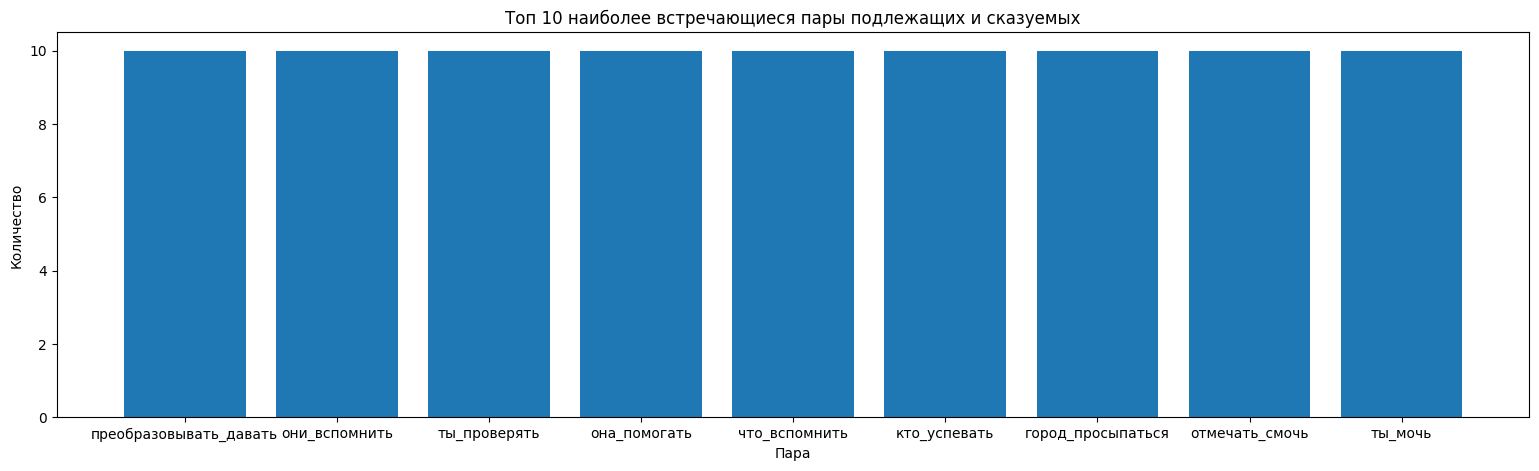

In [53]:
#Гистограмма

plt.figure(figsize=(19, 5))
plt.bar(words_df['pair'], words_df['popularity'])
plt.title('Топ 10 наиболее встречающиеся пары подлежащих и сказуемых')
plt.xlabel('Пара')
plt.ylabel('Количество')
plt.show()

In [56]:
#Чистим датасет от ненужных данных

nltk.download(['averaged_perceptron_tagger_ru', 'stopwords', 'punkt'])

STOP_LIST = nltk.corpus.stopwords.words('russian')

punkt_list = [".", ",", "!", "?", "...", ":", ";"]

for simb in punkt_list:
  STOP_LIST.append(simb)

lemma_words = {
    'word' : []
}

for sent in lemma:
  for word in sent:
    if word[0] not in STOP_LIST:
      #убираем числа
      try:
        if isinstance(int(word[0]), int):
          pass
      except ValueError:
          lemma_words['word'].append(word[0])

lemma_df = pd.DataFrame(lemma_words)

lemma_df

[nltk_data] Downloading package averaged_perceptron_tagger_ru to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,word
0,надоедать
1,читать
2,событие
3,поиграть
4,преобразовывать
...,...
2465,препятствие
2466,подымать
2467,флаг
2468,прямо


In [61]:
# Высчитываем популярные слова
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(lemma_df['word'].head(1000000))

word_pop_count = pd.DataFrame(X.toarray()).sum(axis = 0)


df_pop_words = pd.DataFrame({'word': vectorizer.get_feature_names_out(),
                            'popularity': word_pop_count})

#Топ 10 популярных слов
pw = df_pop_words.sort_values(by=['popularity'], ascending=False).head(10)
pw

,word,popularity
29,день,60.0
104,помогать,60.0
133,россия,40.0
26,давать,40.0
153,становиться,30.0
22,город,30.0
175,честь,30.0
174,человек,30.0
140,семья,30.0
16,вспомнить,30.0


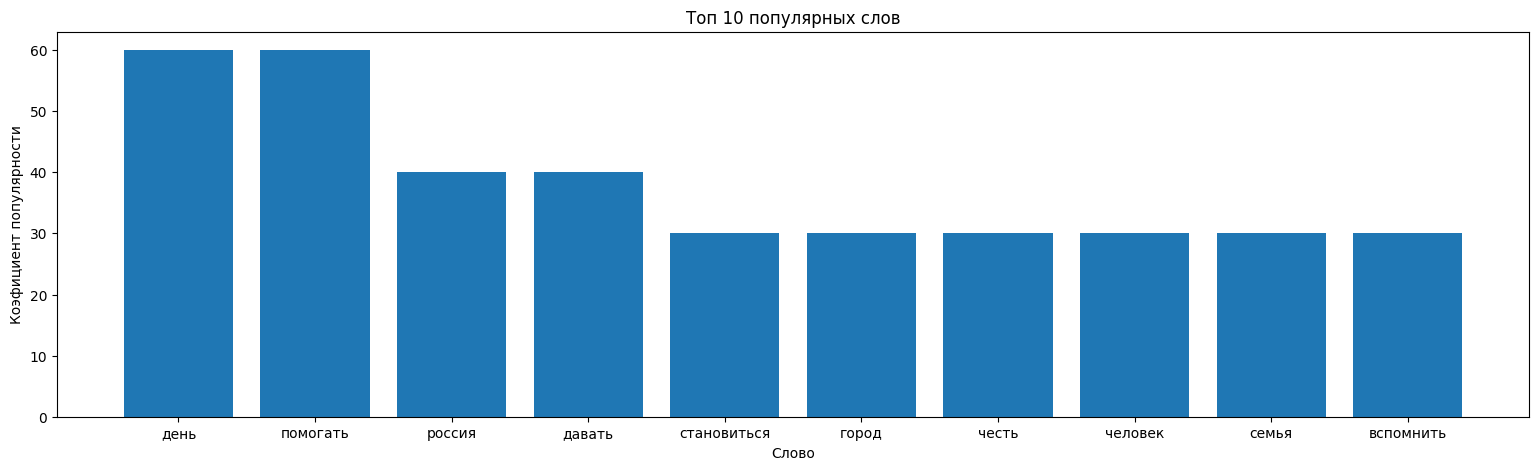

In [60]:
#Гистограмма

plt.figure(figsize=(19, 5))
plt.bar(pw['word'], pw['popularity'])
#sns.histplot(stat_df['popularity'], bins=6, edgecolor='black')
plt.title('Топ 10 популярных слов')
plt.xlabel('Слово')
plt.ylabel('Коэфициент популярности')
plt.show()